In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())

import pandas as pd
import numpy as onp
import pickle
from tqdm.notebook import tqdm
from plotnine import *
import itertools
from scipy.stats import multivariate_normal
from arch.covariance.kernel import Bartlett

from mcmcmd.samplers import *
from mcmcmd.tests import *

from statsmodels.tsa.stattools import acf

import quandl
quandl.ApiConfig.api_key = "7bshxzyy6EjhTArMo4g3"

# Helper functions

In [2]:
# Minnesota prior
class minnesota(object):
    def __init__(self, c, m, q, phi_0, phi_1, phi_2, phi_3, sigma_Y, rng=None):
        if rng is None:
            self._rng = onp.random.default_rng()
        else:
            self._rng = rng
        
        self._c = c # deterministic variables
        self._m = m # number of time series
        self._q = q # number of lags per variable
        self._k = self._m*self._q + self._c # number of regressors

        self._phi_0= phi_0
        self._phi_1= phi_1
        self._phi_2= phi_2
        self._phi_3= phi_3

        self._sigma_Y = sigma_Y

        self._mu_alpha = onp.zeros(shape=(self._k,self._m))
        self._mu_alpha[onp.arange(self._c, self._k, self._q), :] = 1
        self._mu_alpha = self._mu_alpha.reshape(-1, 1)

        Sigma_alpha_diag = onp.ones(shape=(self._k,self._m))*self._phi_0

        # harmonic decay
        h = lambda l: l**self._phi_3
        
        Sigma_alpha_diag[:self._c, :] *= self._phi_2
        for row in range(self._c,self._k):
            for col in range(m):
                i = col + 1
                j = (row-self._c)//self._q + 1
                l = (row-self._c)%self._q + 1
                if i == j:
                    Sigma_alpha_diag[row, col] *= 1./h(l)
                else:
                    Sigma_alpha_diag[row, col] *= self._phi_1/h(l) * (self._sigma_Y[j-1]/self._sigma_Y[i-1])**2

        self._Sigma_alpha = onp.identity(self._m*self._k)
        onp.fill_diagonal(self._Sigma_alpha, Sigma_alpha_diag.reshape(-1, 1).flatten())

        self._distr = multivariate_normal(mean=self._mu_alpha.flatten(), cov=self._Sigma_alpha, seed=self._rng)
        pass

    def set_rng(self, rng):
        self._rng = rng
        self._distr = multivariate_normal(mean=self._mu_alpha.flatten(), cov=self._Sigma_alpha, seed=self._rng)

    def sample(self, num_samples=1):
        return self._distr.rvs(num_samples)
    
    def logpdf(self, alpha):
        return self._distr.log(alpha.flatten())

class bayes_var_sampler(model_sampler):
    def __init__(self, ydata, q, **kwargs):
        self._N = 1
        self._q = q # number of lags per variable
        self._m = ydata.shape[1] # number of time series
        self._c = 1 # deterministic variables. currently just a constant, but ideally should detrend & remove seasonality
        self._k = self._m*self._q + self._c # number of regressors
        self._T = ydata.shape[0] - self._q # length of time series

        # Data parameters
        self._X = onp.hstack([onp.vstack([ydata[:, col][onp.arange(self._q-i-1,ydata.shape[0]-i-1)] for i in range(self._q)]).T for col in range(m)])
        self._X = onp.hstack([onp.ones(shape=(self._T,1)), self._X])
        self._X_tilde = onp.kron(onp.identity(self._m), self._X)
        Y = onp.vstack([ydata[:, col][self._q:] for col in range(m)]).T
        self._y = Y.reshape(self._T*self._m, -1)
        self._sigma_Y = onp.sqrt(onp.array([float(Bartlett(Y[:, j], bandwidth=None).cov.long_run) for j in range(Y.shape[1])]))

        # Derived parameters
        alpha_ols, _, _, _ = onp.linalg.lstsq(a=self._X_tilde, b=self._y, rcond=None)
        epsilon_ols = (self._y - self._X_tilde @ alpha_ols).reshape(self._T, self._m)
        self._Sigma_epsilon = (epsilon_ols.T @ epsilon_ols)/(self._T-1) # Fixed, could place prior
        self._Sigma_epsilon_inv = onp.linalg.inv(self._Sigma_epsilon)
        self._Sigma_epsilon_tilde = onp.kron(self._Sigma_epsilon, onp.identity(self._T))
        self._Sigma_epsilon_tilde_inv = onp.kron(self._Sigma_epsilon_inv, onp.identity(self._T))

        ## Minnesota prior
        # self._phi_0=0.2 
        # self._phi_1=0.5 
        # self._phi_2=1e5
        # self._phi_3=1

        # self._mn_prior = minnesota(c=self._c, m=self._m, q=self._q, phi_0=self._phi_0, phi_1=self._phi_1, phi_2=self._phi_2, phi_3=self._phi_3, sigma_Y=self._sigma_Y)
        # self._mu_alpha = self._mn_prior._mu_alpha
        # self._Sigma_alpha = self._mn_prior._Sigma_alpha

        ## Standard normal priors
        self._mu_alpha = onp.zeros(shape=(self._k*self._m,1))
        self._Sigma_alpha = onp.identity(self._k*self._m)

        super().__init__(**kwargs)
        
        self._Sigma_alpha_inv = onp.linalg.inv(self._Sigma_alpha)
        self._prior_alpha = multivariate_normal(mean=self._mu_alpha.flatten(), cov=self._Sigma_alpha)
        
        assert self._N == 1
        pass
    
    @property
    def sample_dim(self):
        # y, alpha
        return self._N*self._m*self._T + self._m*self._k

    @property
    def theta_indices(self):
        return onp.arange(self._N*self._m*self._T, self.sample_dim)

    def drawPrior(self, rng=None):
        if rng is None:
            rng = self._rng_s
        # self._prior_alpha.set_rng(rng)
        # self._alpha = self._prior_alpha.sample()
        self._alpha = self._prior_alpha.rvs().reshape(-1,1)
        return self._alpha.flatten()
    
    def drawLikelihood(self, rng=None):
        if rng is None:
            rng = self._rng_s
        self._y = multivariate_normal(mean=(self._X_tilde@self._alpha).flatten(), cov=self._Sigma_epsilon_tilde, seed=rng).rvs(self._N).reshape(-1, 1)
        return self._y.flatten()
    
    def drawPosterior(self, rng=None):
        if rng is None:
            rng = self._rng_s
                
        XT_X = self._X.T @ self._X
        Sigma_alpha_post = onp.linalg.inv(self._Sigma_alpha_inv + onp.kron(self._Sigma_epsilon_inv, XT_X))
        mu_alpha_post = Sigma_alpha_post @ (self._Sigma_alpha_inv @ self._mu_alpha + onp.kron(self._Sigma_epsilon_inv, self._X).T @ self._y).flatten()

        self._alpha = multivariate_normal(mean=mu_alpha_post, cov=Sigma_alpha_post, seed=rng).rvs(self._N)
        return self._alpha.flatten()
    

# Error 1: Sigma_epsilon_inverse has a too-large diagonal
class bayes_var_sampler_error_1(bayes_var_sampler):
    def __init__(self, ydata, q, **kwargs):
        super().__init__(ydata, q, **kwargs)
        onp.fill_diagonal(self._Sigma_epsilon_inv, onp.diag(self._Sigma_epsilon_inv)*2)
        pass
        

# [Vector autoregression](http://apps.eui.eu/Personal/Canova/Articles/ch10.pdf) 

We model $m=2$ dependent time series $\{y_{t}\}_{t=1}^{T}, \{z_{t}\}_{t=1}^{T}$ via

\begin{align}
    y_{t} &= \alpha_{1,1} + \alpha_{2,1} y_{t-1} + \ldots + \alpha_{q+1,1} y_{t-q} + \alpha_{q+2,1} z_{t-1} + \ldots + \alpha_{2q+1,1} z_{t-q} + \epsilon_{t,1} \\
    z_{t} &= \alpha_{1,2} + \alpha_{2,2} y_{t-1} + \ldots + \alpha_{q+1,2} y_{t-q} + \alpha_{q+2,2} z_{t-1} + \ldots + \alpha_{2q+1,2} z_{t-q} + \epsilon_{t,2}
\end{align}

In matrix form, this is 
\begin{align}
    \mathbf{Y}_{T \times m} = \mathbf{X}_{T \times k} \mathbf{A}_{k \times m} + \mathbf{E}_{T \times m}
\end{align}
or equivalently
\begin{align}
    \mathbf{y}_{Tm \times 1} = (\mathbf{I}_{m \times m} \otimes \mathbf{X}_{T \times k} )\mathbf{\alpha}_{km \times 1} + \mathbf{\epsilon}_{Tm \times 1}
\end{align}
where $\mathbf{\alpha}=\text{vec}(\mathbf{A}_{k \times m}), \mathbf{\epsilon}_{Tm \times 1}=\text{vec}(\mathbf{E}_{T \times m}) \sim \mathcal{N}(0, \Sigma_{\epsilon} \otimes \mathbf{I}_{T\times T})$, and $\otimes$ denotes the Kronecker product.

We place a normal prior on $\mathbf{\alpha}$ and leave $\mathbf{\Sigma}_{\epsilon}$ fixed.

\begin{align}
    p(\mathbf{\alpha}) = \mathcal{N}(\mathbf{\mu}_{\alpha}, \mathbf{\Sigma}_{\alpha})
\end{align}

There are $mk(mk+1)$ entries in $\{\mathbf{\mu}_{\alpha}, \mathbf{\Sigma}_{\alpha}\}$, which can be unwieldy. Macroeconomists typically reduce the number of hyperparameters by imposing restrictions on these parameters. A specific instance of this is the Minnesota prior, which assumes that each time series is a random walk.

Now we will generate (or alternatively download) some data.

In [3]:
# # Data from quandl
# # ydata = quandl.get(["FRED/FEDFUNDS", "FRED/UNRATE", "RATEINF/INFLATION_USA"], start_date="2010-01-01", end_date="2019-12-31", collapse="quarterly")
# ydata = quandl.get(["FRED/FEDFUNDS", "RATEINF/INFLATION_USA"], start_date="2010-01-01", end_date="2019-12-31", collapse="quarterly")
# sns.lineplot(data=ydata)
# ydata = ydata.to_numpy()

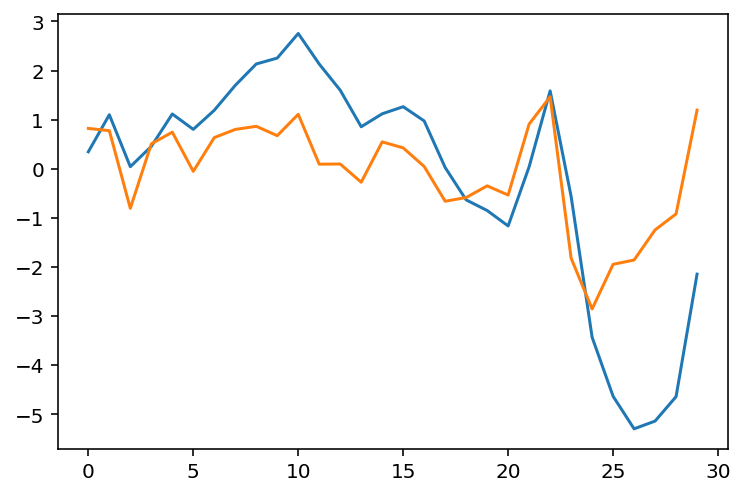

In [4]:
# Generate stationary VAR(1) process
rng = onp.random.default_rng(1)
m = 2
T = 30

Pi = onp.array([[0.8, 0.6],[0.1, 0.5]]) # coefficients
assert onp.abs(onp.linalg.eig(Pi)[0].max()) < 1 # check stationarity

ydata = onp.zeros(shape=(T-1,m))
ydata = onp.vstack([rng.normal(size=(1,m)), ydata]) # initialize

for i in range(1, T):
    ydata[i, :] = (Pi @ ydata[i-1, :].reshape(-1,1)).flatten() + rng.normal()

plt.plot(ydata)

In [5]:
# # Sample
# model = bayes_var_sampler(ydata, q=1, N=1)
# model.set_nproc(2)

# samples_mc = model.sample_mc(100000)
# samples_sc = model.sample_sc(100000)

In [6]:
num_trials = 20
alpha = 0.05

lst_experiments = [bayes_var_sampler(ydata, 1), bayes_var_sampler_error_1(ydata, 1)]
lst_sample_size = [10000, 20000, 30000]

df_results = pd.DataFrame(index=onp.arange(0, 3*len(lst_experiments)*len(lst_sample_size)), columns=('experiment', 'test_type', 'sample_size', 'result'))

i = 0
for model in tqdm(lst_experiments):
    for n in tqdm(lst_sample_size):
        mmd_test_size = 5000
        
        rej_geweke = 0
        rej_mmd_wb = 0
        rej_mmd = 0
        for _ in tqdm(range(num_trials)):
            samples_mc = model.sample_mc(n)
            samples_sc = model.sample_sc(n)
            samples_bc = model.sample_bc(n, 5)
   
            rej_geweke += geweke_test(model.test_functions(samples_mc[:, model.theta_indices]), model.test_functions(samples_sc[:, model.theta_indices]), l=0.08, alpha=0.05)['result'].max()
            rej_mmd_wb += mmd_wb_test(samples_mc[:int(mmd_test_size)][:, model.theta_indices], samples_sc[onp.arange(0, int(n), int(n/mmd_test_size)), :][:, model.theta_indices], alpha=0.05)['result']
            rej_mmd += mmd_test(samples_mc[:int(mmd_test_size)][:, model.theta_indices], samples_bc[onp.arange(0, int(n), int(n/mmd_test_size)), :][:, model.theta_indices], alpha=0.05)['result']

        rej_geweke /= num_trials
        rej_mmd_wb /= num_trials
        rej_mmd /= num_trials
        df_results.loc[i+0] = [type(model).__name__, 'geweke', n, rej_geweke]
        df_results.loc[i+1] = [type(model).__name__, 'mmd_wb', n, rej_mmd_wb]
        df_results.loc[i+2] = [type(model).__name__, 'mmd', n, rej_mmd]
        i += 3
df_results['result'] = pd.to_numeric(df_results['result'])

In [9]:
df_results

,experiment,test_type,sample_size,result
0,bayes_var_sampler,geweke,10000,0.1
1,bayes_var_sampler,mmd_wb,10000,0.3
2,bayes_var_sampler,mmd,10000,0.05
3,bayes_var_sampler,geweke,20000,0.35
4,bayes_var_sampler,mmd_wb,20000,0.45
5,bayes_var_sampler,mmd,20000,0
6,bayes_var_sampler,geweke,30000,0.2
7,bayes_var_sampler,mmd_wb,30000,0.35
8,bayes_var_sampler,mmd,30000,0.15
9,bayes_var_sampler_error_1,geweke,10000,1


/Users/andrew/miniconda3/envs/shogun/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/andrew/miniconda3/envs/shogun/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: Bayes_VAR.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


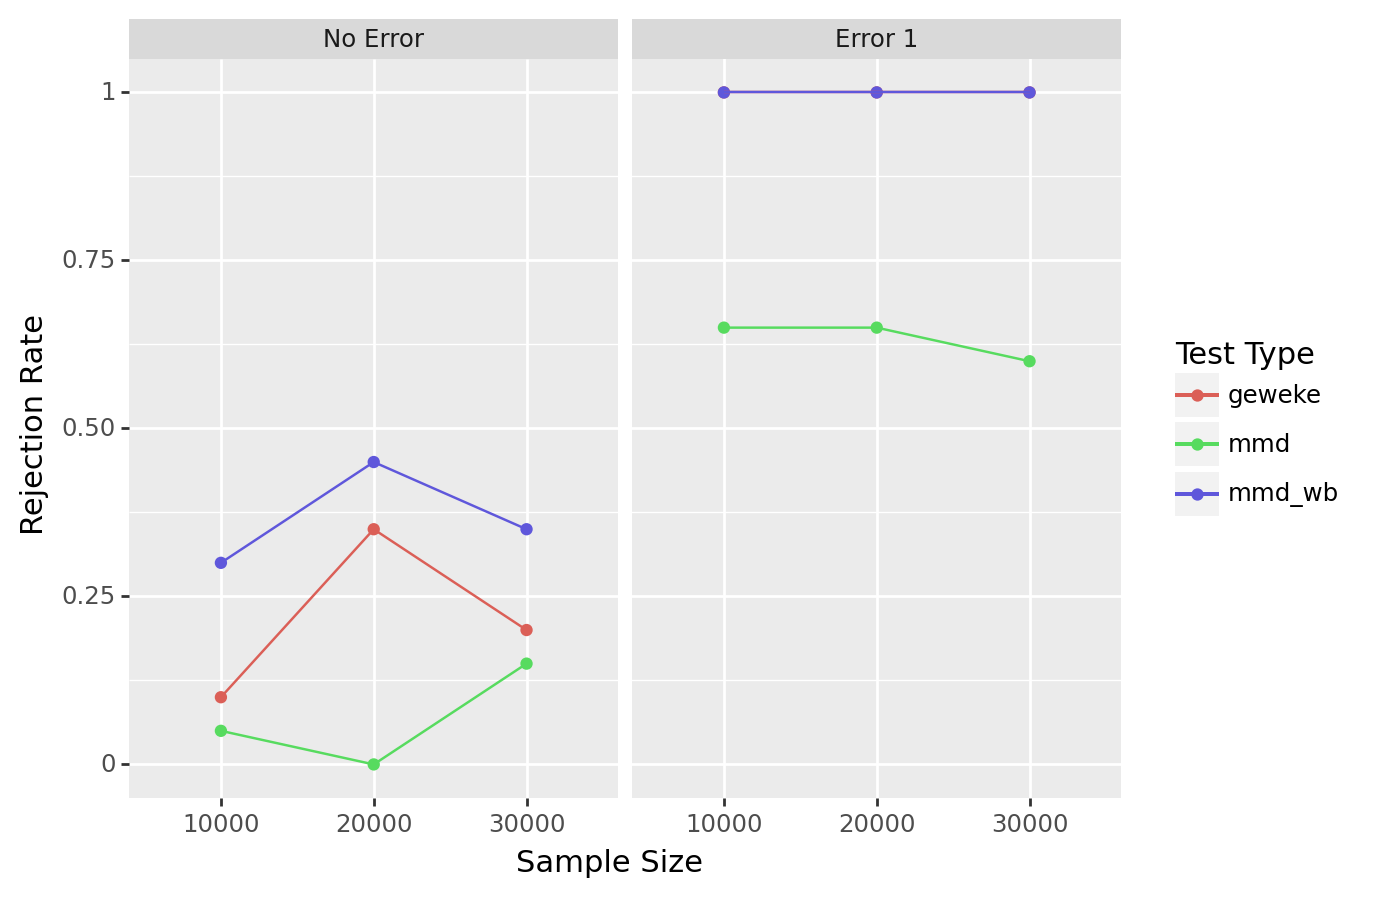

<ggplot: (8778410768325)>

In [13]:
def exp_label(x):
    if 'error' in x:
        return f'Error {x[-1]}'
    else:
        return 'No Error'

plot_results=ggplot(df_results, aes(x='sample_size', y='result', color='test_type', group='test_type')) + \
    geom_point() + geom_line() +\
    facet_grid('~experiment', labeller=exp_label) +\
    labs(x='Sample Size', y='Rejection Rate', title='', color='Test Type') + scale_y_continuous()
ggsave(plot_results, 'Bayes_VAR.png')
plot_results